###Install AutoKeras

In [1]:
!pip3 install autokeras

     |████████████████████████████████| 174kB 17.3MB/s 
     |████████████████████████████████| 71kB 10.8MB/s 
  Created wheel for keras-tuner: filename=keras_tuner-1.0.2-cp37-none-any.whl size=78938 sha256=beb417b9f3c54f1c61307235b3b698bc52d215b1fa55067e17d297417a19c28b
  Stored in directory: /root/.cache/pip/wheels/bb/a1/8a/7c3de0efb3707a1701b36ebbfdbc4e67aedf6d4943a1f463d6
  Created wheel for terminaltables: filename=terminaltables-3.1.0-cp37-none-any.whl size=15356 sha256=b8b2aaca17ff01178d27dbde29a21a8b459f96a78d9ffe0d9e58b22c0b6c8775
  Stored in directory: /root/.cache/pip/wheels/30/6b/50/6c75775b681fb36cdfac7f19799888ef9d8813aff9e379663e
Successfully built keras-tuner terminaltables


In [2]:
import matplotlib.pyplot as plt
import autokeras as ak
from tensorflow.keras.datasets import cifar10 

### Getting the CIFAR-10 dataset 

In [3]:
# Prepare the dataset.
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
print(x_train.shape) 
print(x_test.shape) 


170500096/170498071 [==============================] - 2s 0us/step
(50000, 32, 32, 3)
(10000, 32, 32, 3)


### How the image classes are distributed?

When we are working with data sets, it is very important to check that the data is distributed homogeneously, this can be done easily using numpy functions.

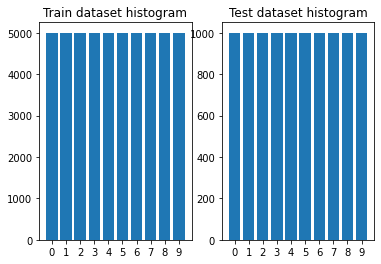

In [4]:
import numpy as np

train_histogram = np.histogram(y_train)
test_histogram = np.histogram(y_test)
_, axs = plt.subplots(1, 2)
axs[0].set_xticks(range(10))
axs[0].bar(range(10), train_histogram[0])
axs[0].set_title('Train dataset histogram')
axs[1].set_xticks(range(10))
axs[1].bar(range(10), test_histogram[0])
axs[1].set_title('Test dataset histogram')
plt.show()

### Creating and training the models

In [ ]:
# Initialize the ImageClassifier.
clf = ak.ImageClassifier(max_trials=1)
# Search for the best model.
clf.fit(x_train, y_train)


Search: Running Trial #1

Hyperparameter    |Value             |Best Value So Far 
image_block_1/b...|vanilla           |?                 
image_block_1/n...|True              |?                 
image_block_1/a...|False             |?                 
image_block_1/c...|3                 |?                 
image_block_1/c...|1                 |?                 
image_block_1/c...|2                 |?                 
image_block_1/c...|True              |?                 
image_block_1/c...|False             |?                 
image_block_1/c...|0.25              |?                 
image_block_1/c...|32                |?                 
image_block_1/c...|64                |?                 
classification_...|flatten           |?                 
classification_...|0.5               |?                 
optimizer         |adam              |?                 
learning_rate     |0.001             |?                 

Epoch 1/1000
1251/1251 [==============================] - 39

### Evaluating the best model

In [ ]:
metrics = clf.evaluate(x_test, y_test) 
print(metrics) 

313/313 [==============================] - 1s 3ms/step - loss: 1.0267 - accuracy: 0.6456
[1.026714563369751, 0.6456000208854675]


### Improving the model search

If we need more precision in less time, we can fine-tune our model using an advanced Autokeras feature that allows you to customize your search space.

Using AutoModel with ImageBlock instead of ImageClassifier, we can create high-level configurations, such as block_type for the type of neural network to look for, we can also perform data normalization or perform data augmentation.

If we have knowledge of deep learning and have faced this problem before, we can design a suitable architecture as a EfficientNet-based image regressor, for instance, which is a deep residual learning architecture for image recognition. https://keras.io/api/applications/efficientnet/ 

In [ ]:
input_node = ak.ImageInput()
output_node = ak.EfficientNetBlock(
    # Only use EfficientNetb7 architecture.
    version="b7",
    # Load pretrained ImageNet weights 
    pretrained=True)(input_node)
output_node = ak.ClassificationHead()(output_node)
# Search for the best model with EarlyStopping.
from tensorflow.keras import callbacks as tf_callbacks
cbs = [
    tf_callbacks.EarlyStopping(patience=2, verbose=1),
]
clf = ak.AutoModel(
    inputs=input_node,
    outputs=output_node,
    overwrite=False,
    max_trials=10,
    objective='val_accuracy')
clf.fit(x_train, y_train, callbacks = cbs, verbose=1, epochs=10)


Trial 5 Complete [01h 46m 23s]
val_accuracy: 0.3829253613948822

Best val_accuracy So Far: 0.3829253613948822
Total elapsed time: 02h 19m 36s

Search: Running Trial #6

Hyperparameter    |Value             |Best Value So Far 
efficient_net_b...|True              |True              
classification_...|flatten           |flatten           
classification_...|0.5               |0.5               
optimizer         |sgd               |adam              
learning_rate     |0.001             |0.001             
efficient_net_b...|True              |True              

Epoch 1/10
Not enough memory, reduce batch size to 16.
Epoch 1/10
2502/2502 [==============================] - 1561s 624ms/step - loss: 0.7697 - accuracy: 0.7550 - val_loss: 0.3888 - val_accuracy: 0.8745
Epoch 2/10
2502/2502 [==============================] - 1562s 624ms/step - loss: 0.3041 - accuracy: 0.9004 - val_loss: 0.3177 - val_accuracy: 0.8950
Epoch 3/10
2502/2502 [==============================] - 1563s 625ms/step - los

In [ ]:
# Evaluate the chosen model with testing data
print(x_test.shape)
print(y_test.shape)
clf.evaluate(x_test, y_test)

(10000, 32, 32, 3)
(10000, 1)
313/313 [==============================] - 110s 337ms/step - loss: 0.1049 - accuracy: 0.9711


[0.10493050515651703, 0.9710999727249146]

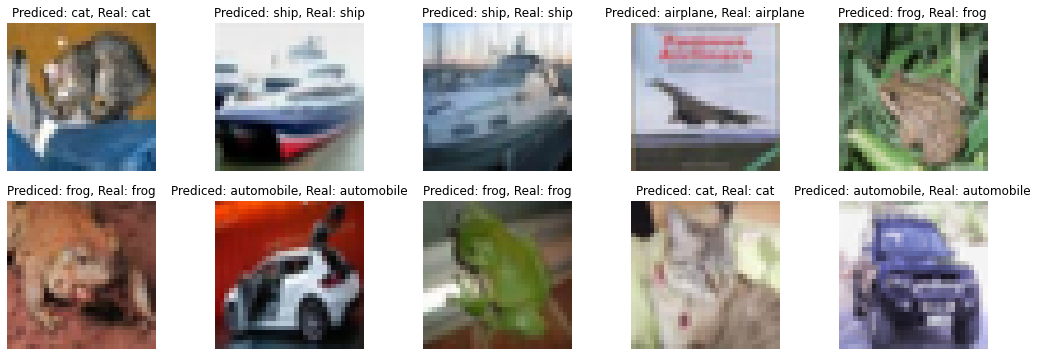

In [ ]:
predicted_y = clf.predict(x_test[:10]).argmax(axis=1)
labelNames = ["airplane", "automobile", "bird", "cat", "deer",
        "dog", "frog", "horse", "ship", "truck"]
fig = plt.figure(figsize=[18,6])
for i in range(len(predicted_y)):
    ax = fig.add_subplot(2, 5, i+1)
    ax.set_axis_off()
    ax.set_title('Prediced: %s, Real: %s' % (labelNames[int(predicted_y[i])], labelNames[int(y_test[i])]))
    img = x_test[i]
    ax.imshow(img)
plt.show()

###Visualizing the model

In [ ]:
# First we export the model to a keras model
model = clf.export_model()

# Now, we ask for the model Sumary:
clf.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
cast_to_float32 (CastToFloat (None, 32, 32, 3)         0         
_________________________________________________________________
normalization (Normalization (None, 32, 32, 3)         7         
_________________________________________________________________
random_translation (RandomTr (None, 32, 32, 3)         0         
_________________________________________________________________
random_flip (RandomFlip)     (None, 32, 32, 3)         0         
_________________________________________________________________
resizing (Resizing)          (None, 224, 224, 3)       0         
_________________________________________________________________
efficientnetb7 (Functional)  (None, None, None, 2560) 

Visualizing the classifier model

Now we can take a look at the architecture of the best generated model

As we did with the classifier, there is a more visual way to see it

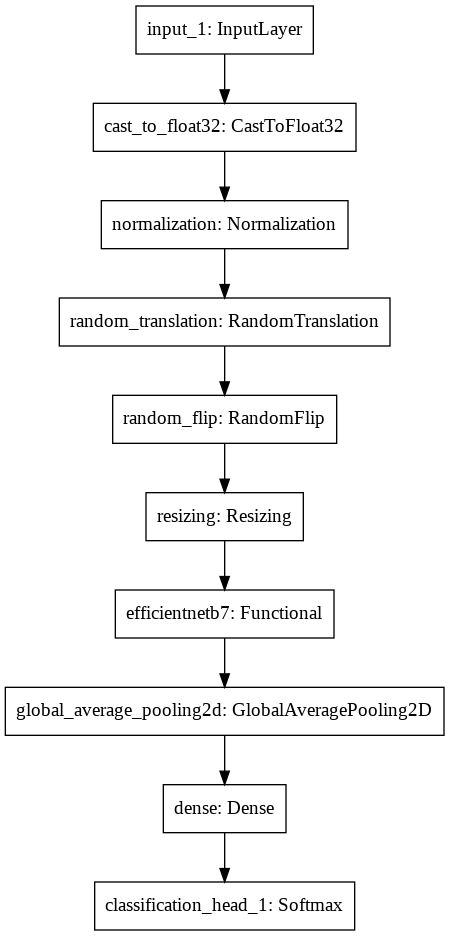

In [ ]:
from tensorflow.keras.utils import plot_model
plot_model(clf.export_model())